# Importanje Library-a

In [1]:
%pip install scikit-optimize
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import randint,uniform
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt.pyll.base import scope
from functools import partial
import random
from skopt import space
from skopt import gp_minimize

RANDOM_STATE = random.randint(1,10000)
N_SPLITS = 10
kf = KFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle=True)
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=RANDOM_STATE, shuffle= True)
SCORING = "roc_auc"
EVALS_IN_HYPEROPT = 3000
EVALS_IN_BAYESIAN = 500
EVALS_IN_RANDOM = 5000

FOLDS = skf
N_JOBS = -1

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [2]:
def print_params(classifier):
  print("Trenutni parametri modela:")
  for param, value in classifier.get_params().items():
    print(f"{param}: {value}")

In [3]:
def print_scores_with_cross_val(classifier, optimization_algo = ""):
  print(f'Točnost modela {optimization_algo} sa unakrsnom provjerom: {round(cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).mean() * 100, ndigits=2)}%')
  print(f'Standardna devijacija modela {optimization_algo} sa unakrnsom provjerom: {round(cross_val_score(classifier, X, y, cv=FOLDS, scoring="accuracy", n_jobs=N_JOBS).std() * 100, ndigits=2)} %')
  print(f'ROC AUC vrijednost modela {optimization_algo} : {round(cross_val_score(classifier, X, y, cv=FOLDS, scoring="roc_auc", n_jobs=N_JOBS).mean() * 100, ndigits=2)} %')
  print(f'F1 vrijednost modela {optimization_algo} : {round(cross_val_score(classifier, X, y, cv=FOLDS, scoring="f1", n_jobs=N_JOBS).mean() * 100, ndigits=2)} %')

# Importanje Dataseta

In [4]:
dataset = pd.read_csv('heart.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [5]:
dataset.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
dataset.tail()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [7]:
dataset.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Predprocesiranje podataka

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, shuffle=True)

In [10]:
lgbm_classic= LGBMClassifier(random_state=RANDOM_STATE)

# Treniranje modela i predviđanje 

In [11]:
lgbm_classic.fit(X_train, y_train)
y_pred = lgbm_classic.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"Točnost LGBM klasifikatora bez unakrsne provjere: {lgbm_classic.score(X_test, y_test) * 100} %")

[[24  4]
 [ 4 29]]
Točnost LGBM klasifikatora bez unakrsne provjere: 86.88524590163934 %


# Optimizacija modela

In [12]:
print_params(lgbm_classic)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: -1
num_leaves: 31
objective: None
random_state: 3756
reg_alpha: 0.0
reg_lambda: 0.0
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


 # Grid Search


In [13]:
%%time
params_grid_search = {'learning_rate': [0.001, 0.01, 0.5],
          'num_leaves': [10, 20, 150, 300],
          'n_estimators': [500, 1500, 3000],
          'max_depth': [3, 8, 12],
          'min_child_samples': [5, 30, 150],
          'reg_lambda': [1, 50, 99],
          'reg_alpha' : [1, 50, 99]}
grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=RANDOM_STATE),
                           param_grid=params_grid_search,
                           scoring=SCORING,
                           cv=FOLDS,
                           n_jobs=N_JOBS,
                           return_train_score=True,
                           verbose=10)
grid_search.fit(X, y)
print(f"Najbolja točnost sa Grid Search-om: {grid_search.best_score_ * 100} %")
print(f"Najbolji parametri sa Grid Search-om: {grid_search.best_params_}")

Fitting 10 folds for each of 2916 candidates, totalling 29160 fits
Najbolja točnost sa Grid Search-om: 91.84510342598578 %
Najbolji parametri sa Grid Search-om: {'learning_rate': 0.01, 'max_depth': 8, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 1}
CPU times: total: 21.5 s
Wall time: 5min 37s


In [14]:
lgbm_grid_search = LGBMClassifier(**grid_search.best_params_)
lgbm_grid_search.set_params(random_state = RANDOM_STATE )
print_params(lgbm_grid_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.01
max_depth: 8
min_child_samples: 30
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 500
n_jobs: -1
num_leaves: 10
objective: None
random_state: 3756
reg_alpha: 1
reg_lambda: 1
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

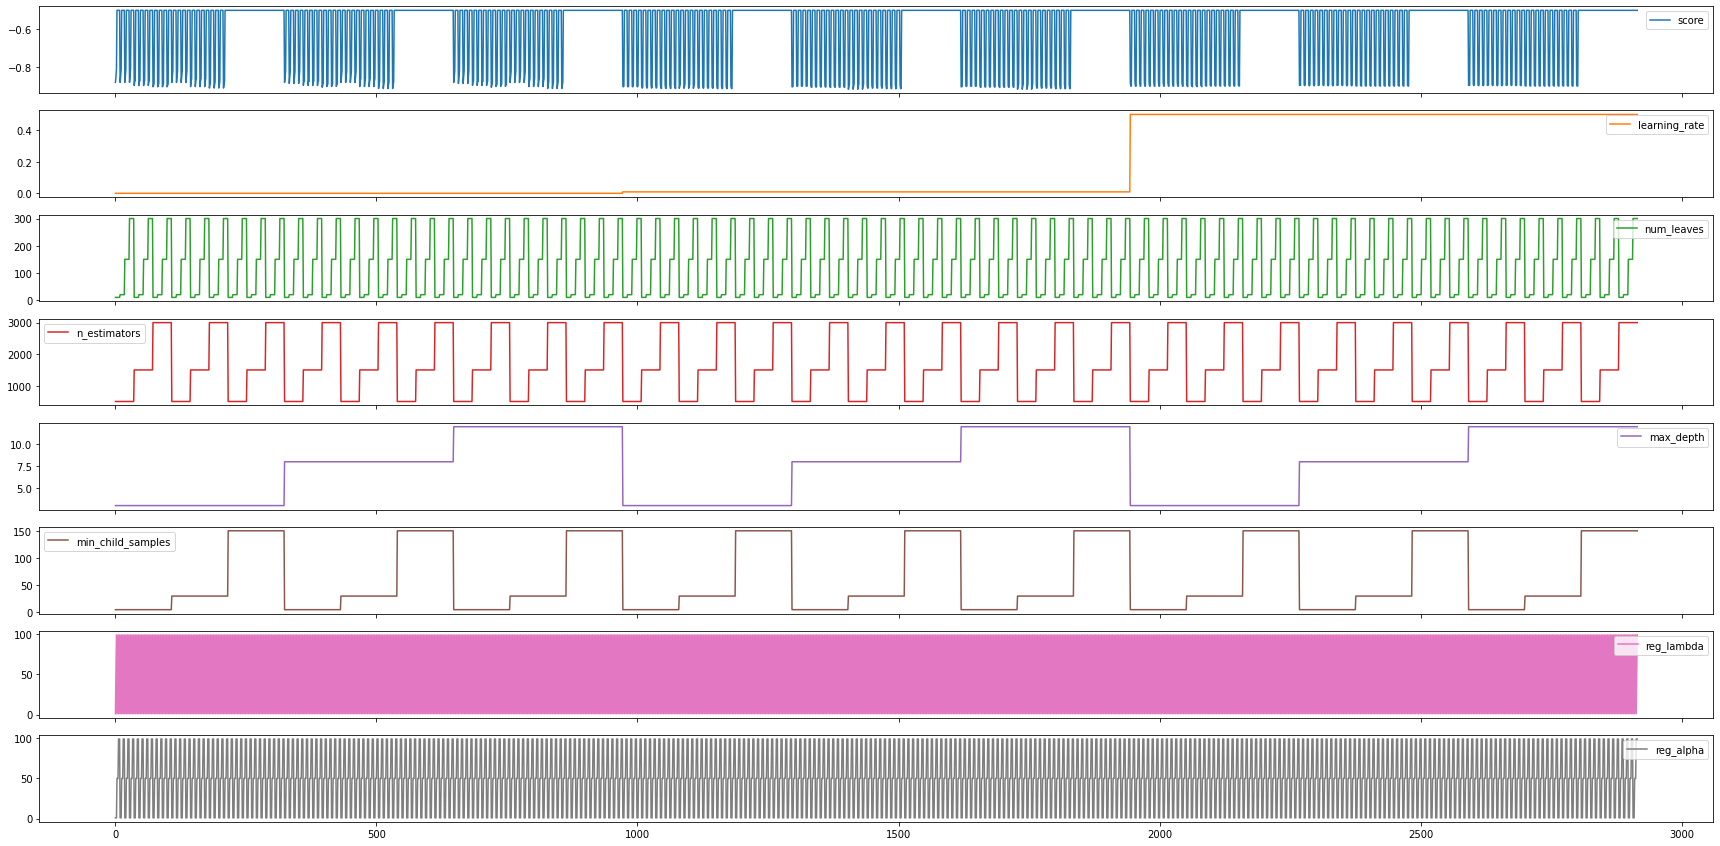

In [15]:
grid_search_scores = grid_search.cv_results_
grid_search_results_df=pd.DataFrame(np.transpose([-grid_search_scores['mean_test_score'],
                                         grid_search_scores['param_learning_rate'].data,
                                         grid_search_scores['param_num_leaves'].data,
                                         grid_search_scores['param_n_estimators'].data,
                                         grid_search_scores['param_max_depth'].data,
                                         grid_search_scores['param_min_child_samples'].data,
                                         grid_search_scores['param_reg_lambda'].data,
                                         grid_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
grid_search_results_df.plot(subplots=True, figsize=(30, 15))

# Random Search


In [16]:
%%time
params_random_search = {'learning_rate' : uniform(0.01,0.99),
          'num_leaves': randint(20,3000),
          'n_estimators': randint(500,3000),
          'max_depth': randint(3,12),
          'min_child_samples': randint(2,300),
          'reg_lambda': uniform(0.01,99.99),
          'reg_alpha': uniform(0.01,99.99),
          }
random_search = RandomizedSearchCV(estimator = LGBMClassifier(random_state=RANDOM_STATE),
                                   param_distributions = params_random_search,
                                   n_iter = EVALS_IN_RANDOM,
                                   scoring = SCORING,
                                   cv = FOLDS,
                                   random_state = RANDOM_STATE,
                                   n_jobs = N_JOBS,
                                   verbose=10
                                   )
random_search.fit(X, y)
print("Najbolja točnost sa Random Search-om: {:.2f} %".format(random_search.best_score_*100))
print("Najbolji parametri prema Random Search-om:", random_search.best_params_)

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits
Najbolja točnost sa Random Search-om: 92.30 %
Najbolji parametri prema Random Search-om: {'learning_rate': 0.1092752295906971, 'max_depth': 7, 'min_child_samples': 18, 'n_estimators': 2324, 'num_leaves': 1568, 'reg_alpha': 3.4982991494330395, 'reg_lambda': 62.037627830084354}
CPU times: total: 34.4 s
Wall time: 5min 20s


In [17]:
lgbm_random_search = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_random_search.set_params(**random_search.best_params_)
print_params(lgbm_random_search)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1092752295906971
max_depth: 7
min_child_samples: 18
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2324
n_jobs: -1
num_leaves: 1568
objective: None
random_state: 3756
reg_alpha: 3.4982991494330395
reg_lambda: 62.037627830084354
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

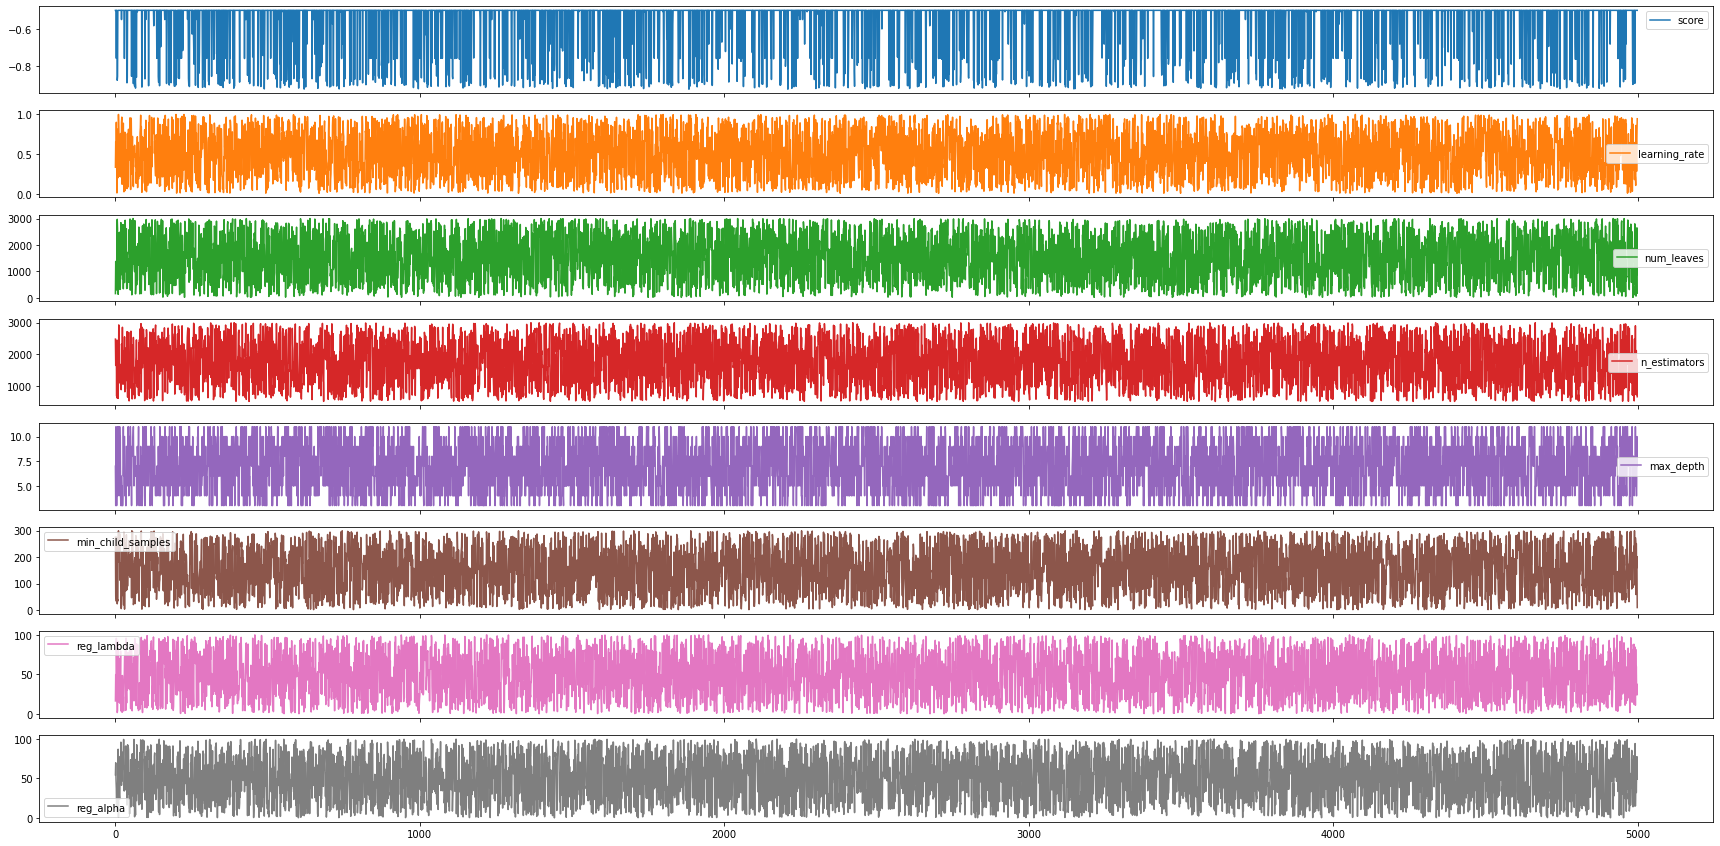

In [18]:
random_search_scores = random_search.cv_results_
random_search_results_df=pd.DataFrame(np.transpose([-random_search_scores['mean_test_score'],
                                         random_search_scores['param_learning_rate'].data,
                                         random_search_scores['param_num_leaves'].data,
                                         random_search_scores['param_n_estimators'].data,
                                         random_search_scores['param_max_depth'].data,
                                         random_search_scores['param_min_child_samples'].data,
                                         random_search_scores['param_reg_lambda'].data,
                                         random_search_scores['param_reg_alpha'].data]),
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
random_search_results_df.plot(subplots=True, figsize=(30, 15))


# HyperOpt


In [19]:
def optimize_hp(params, x, y ):
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

space_hyperopt = {
    'learning_rate' : hp.uniform('learning_rate', 0.001 ,1),
    'num_leaves' : scope.int(hp.quniform('num_leaves', 20,3000,1)),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 500,3000,1)),
    'max_depth' : scope.int(hp.quniform('max_depth', 3, 12,1)),
    'min_child_samples' : scope.int(hp.quniform('min_child_samples', 2, 300,1)),
    'reg_lambda' : hp.uniform('reg_lambda', 0.01 ,100),
    'reg_alpha' : hp.uniform('reg_alpha', 0.01 ,100),
}


optimization_function_hp = partial(optimize_hp, x= X, y = y)

In [20]:
%%time
trials_anneal = Trials()
result_anneal = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = anneal.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_anneal)
print(result_anneal)

100%|██████████| 3000/3000 [16:30<00:00,  3.03trial/s, best loss: -0.925450468648998] 
{'learning_rate': 0.03217203120135238, 'max_depth': 5.0, 'min_child_samples': 65.0, 'n_estimators': 2342.0, 'num_leaves': 1416.0, 'reg_alpha': 2.621615128887446, 'reg_lambda': 38.18206514665476}
CPU times: total: 1min 38s
Wall time: 16min 31s


In [21]:
result_anneal["num_leaves"] = int(result_anneal["num_leaves"])
result_anneal["n_estimators"] = int(result_anneal["n_estimators"])
result_anneal["max_depth"] = int(result_anneal["max_depth"])
result_anneal["min_child_samples"] = int(result_anneal["min_child_samples"])
lgbm_anneal = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_anneal.set_params(**result_anneal)
print_params(lgbm_anneal)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.03217203120135238
max_depth: 5
min_child_samples: 65
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2342
n_jobs: -1
num_leaves: 1416
objective: None
random_state: 3756
reg_alpha: 2.621615128887446
reg_lambda: 38.18206514665476
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

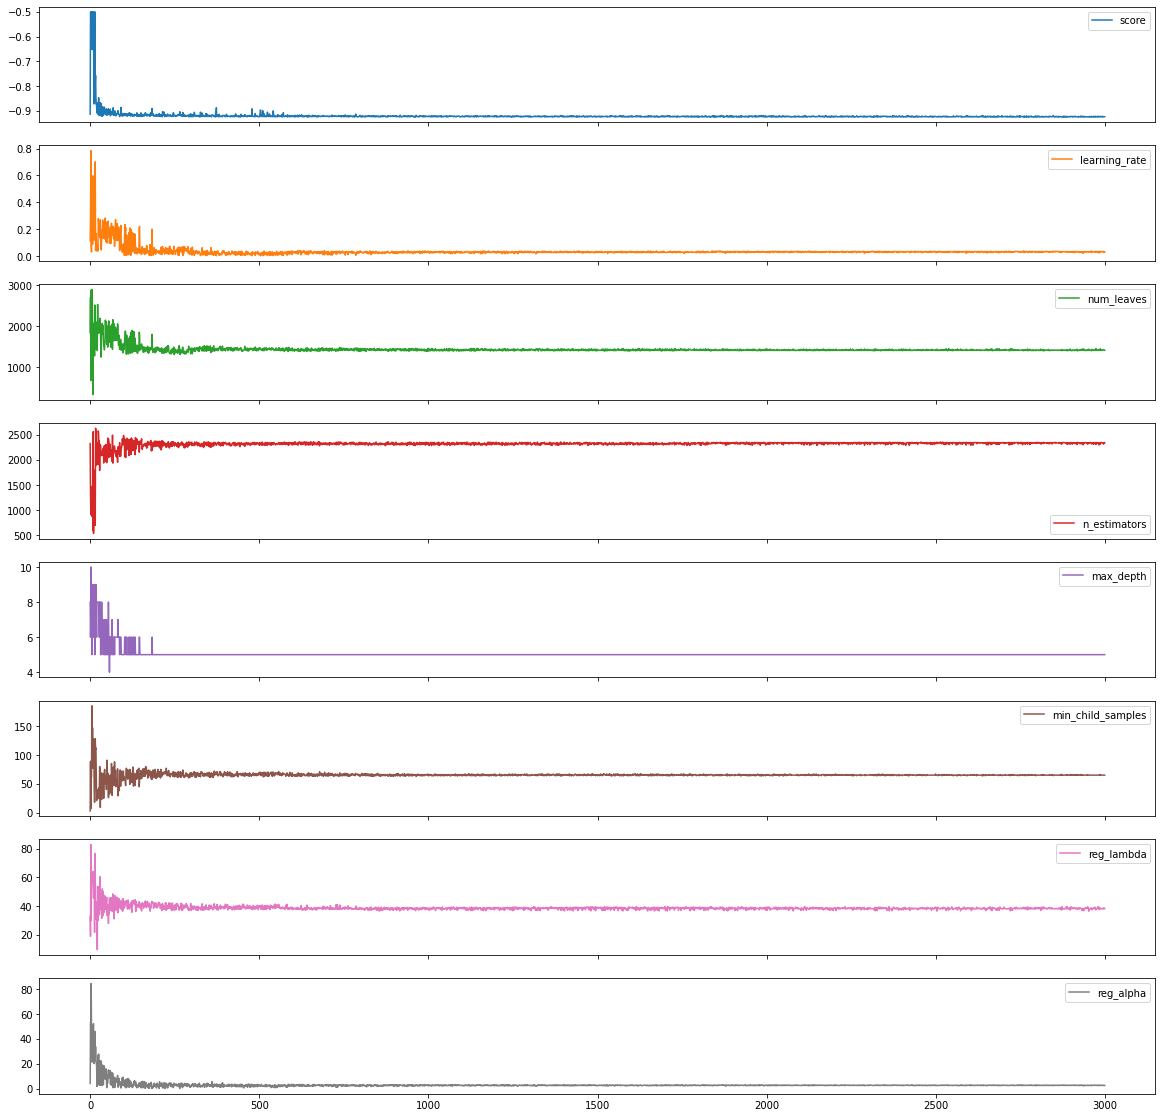

In [22]:
anneal_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_anneal.trials])

anneal_results_df=pd.DataFrame(anneal_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
anneal_results_df.plot(subplots=True,figsize=(20, 20))

In [23]:
%%time
trials_tpe = Trials()
result_tpe = fmin(fn=optimization_function_hp, space = space_hyperopt, algo = tpe.suggest, max_evals = EVALS_IN_HYPEROPT, trials = trials_tpe)
print(result_tpe)

100%|██████████| 3000/3000 [17:43<00:00,  2.82trial/s, best loss: -0.9245192307692307]
{'learning_rate': 0.6242690529591417, 'max_depth': 3.0, 'min_child_samples': 70.0, 'n_estimators': 1439.0, 'num_leaves': 2117.0, 'reg_alpha': 2.5127573893173416, 'reg_lambda': 24.078511185424517}
CPU times: total: 12min
Wall time: 17min 43s


In [24]:
result_tpe["num_leaves"] = int(result_tpe["num_leaves"])
result_tpe["n_estimators"] = int(result_tpe["n_estimators"])
result_tpe["max_depth"] = int(result_tpe["max_depth"])
result_tpe["min_child_samples"] = int(result_tpe["min_child_samples"])
lgbm_tpe = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_tpe.set_params(**result_tpe)
print_params(lgbm_tpe)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.6242690529591417
max_depth: 3
min_child_samples: 70
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 1439
n_jobs: -1
num_leaves: 2117
objective: None
random_state: 3756
reg_alpha: 2.5127573893173416
reg_lambda: 24.078511185424517
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

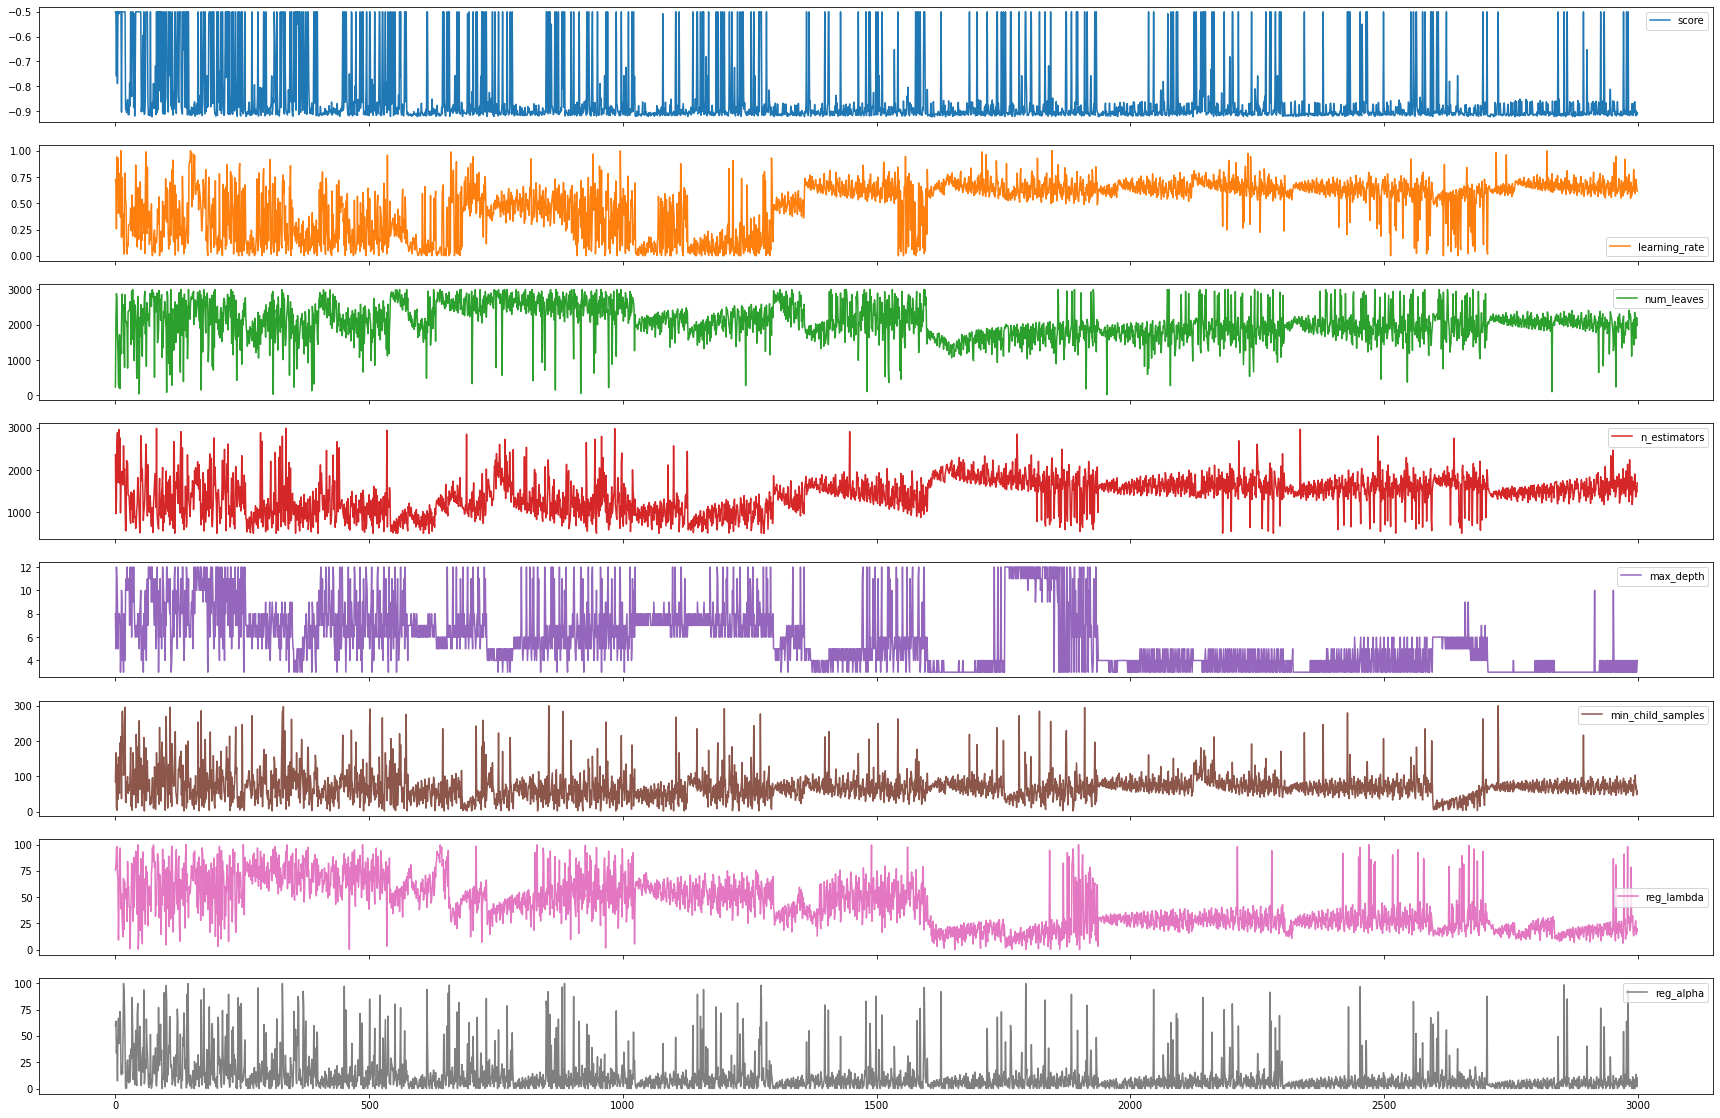

In [25]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['num_leaves'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_child_samples'][0],
                      x['misc']['vals']['reg_lambda'][0],
                      x['misc']['vals']['reg_alpha'][0]] for x in trials_tpe.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'num_leaves', 'n_estimators', 'max_depth', 'min_child_samples', 'reg_lambda', 'reg_alpha'])
tpe_results_df.plot(subplots=True,figsize=(30, 20))


# Bayesian Optimization


In [26]:
def optimize_bayesian(params, param_names ,x, y):
    params = dict(zip(param_names, params))
    model = LGBMClassifier(**params)
    return -1.0 * np.mean(cross_val_score(model, x, y, cv=FOLDS, scoring=SCORING, n_jobs=N_JOBS))

In [27]:
%%time
param_space = [
               space.Real(0.001,1, prior = "uniform", name = "learning_rate"),
               space.Integer(20,3000, name = "num_leaves"),
               space.Integer(500,3000, name = "n_estimators"),
               space.Integer(3,12, name = "max_depth"),
               space.Integer(2,300, name = "min_child_samples"),
               space.Real(0.01,100, prior = "uniform", name = "reg_lambda"),
               space.Real(0.01,100, prior = "uniform", name = "reg_alpha")
]

param_names=[
             "learning_rate",
             "num_leaves",
             "n_estimators",
             "max_depth",
             "min_child_samples",
             "reg_lambda",
             "reg_alpha",
]

optimization_function_bayesian = partial(optimize_bayesian, param_names = param_names, x = X, y= y)
result_bayesian = gp_minimize(optimization_function_bayesian, dimensions = param_space, n_calls = EVALS_IN_BAYESIAN, n_initial_points=10, verbose=10, n_jobs=N_JOBS)

bayesian_parameters = dict(zip(param_names, result_bayesian.x))
print(bayesian_parameters)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0410
Function value obtained: -0.5000
Current minimum: -0.5000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0900
Function value obtained: -0.5000
Current minimum: -0.5000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0690
Function value obtained: -0.8865
Current minimum: -0.8865
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0530
Function value obtained: -0.5000
Current minimum: -0.8865
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1240
Function value obtained: -0.7574
Current minimum: -0.8865
Iteration No: 6 started. 

In [28]:
lgbm_bayesian = LGBMClassifier(random_state=RANDOM_STATE)
lgbm_bayesian.set_params(**bayesian_parameters)
print_params(lgbm_bayesian)

Trenutni parametri modela:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.6638741310539517
max_depth: 12
min_child_samples: 62
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 2210
n_jobs: -1
num_leaves: 20
objective: None
random_state: 3756
reg_alpha: 5.889141882002036
reg_lambda: 0.01
silent: warn
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

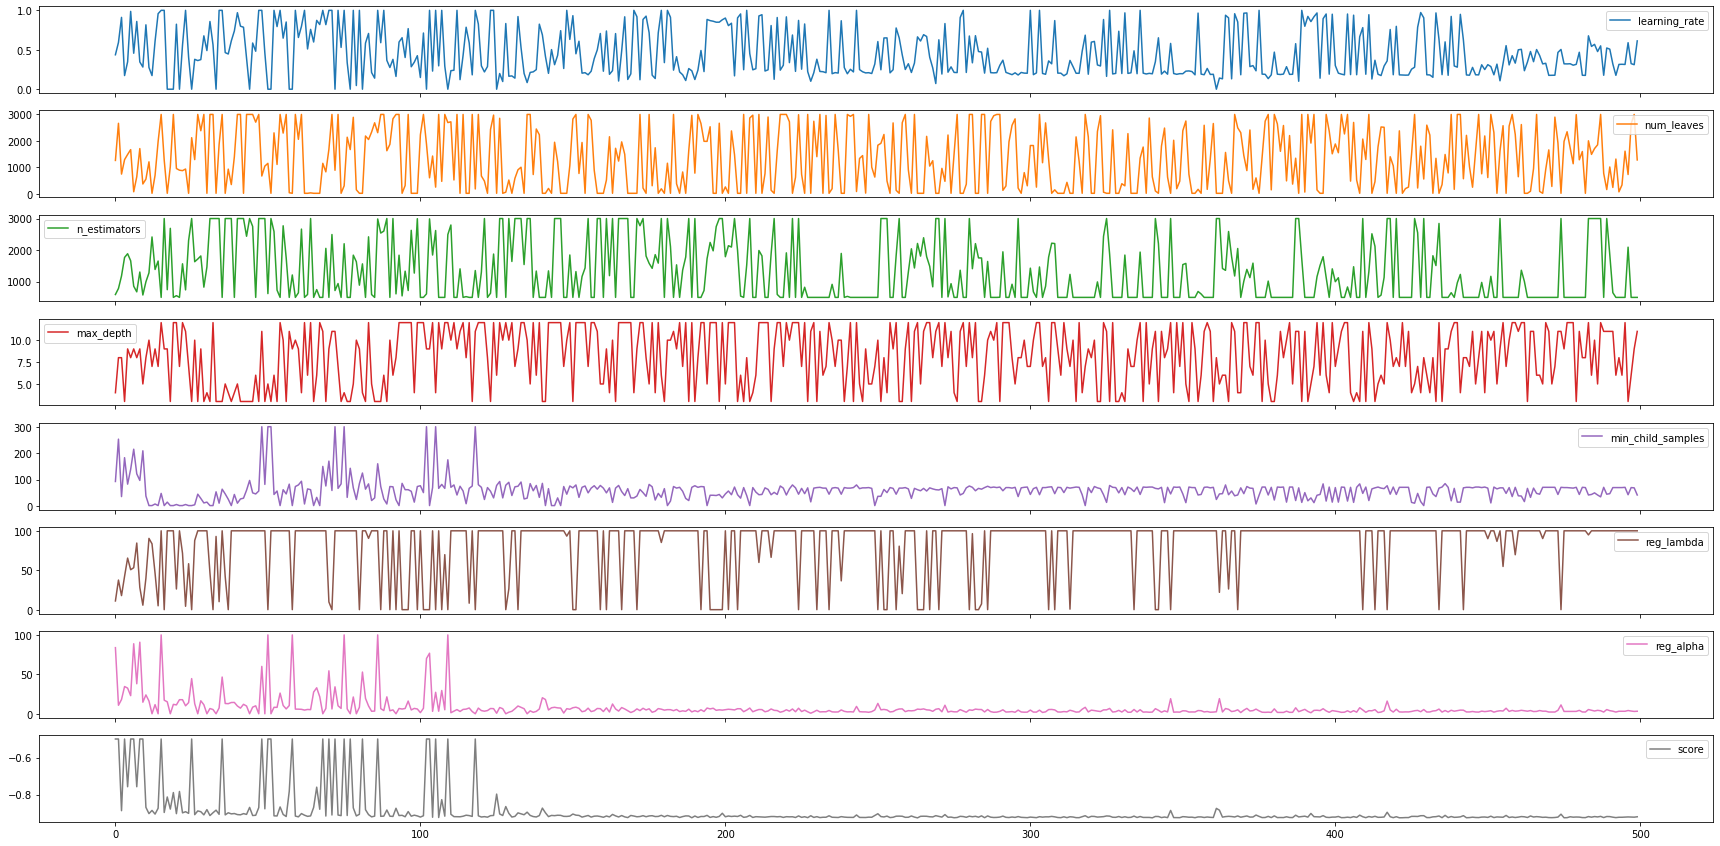

In [29]:
bayesian_results_df = pd.DataFrame(result_bayesian.x_iters)
list_of_scores = result_bayesian.func_vals.tolist()
bayesian_results_df['score'] = list_of_scores

bayesian_results_df.columns=('learning_rate','num_leaves','n_estimators','max_depth', "min_child_samples", "reg_lambda", "reg_alpha",'score')
bayesian_results_df.plot(subplots=True,figsize=(30, 15))

# Usporedba rezultata

In [30]:
print_scores_with_cross_val(lgbm_classic, "bez optimizacije")
print("\n")
print_scores_with_cross_val(lgbm_grid_search, "s Grid Search-om")
print("\n")
print_scores_with_cross_val(lgbm_random_search, "s Random Searchom-om")
print("\n")
print_scores_with_cross_val(lgbm_anneal, "s Hyperopt-Anneal")
print("\n")
print_scores_with_cross_val(lgbm_tpe, "s Hyperopt-Tpe")
print("\n")
print_scores_with_cross_val(lgbm_bayesian, "s Bayesian")

Točnost modela bez optimizacije sa unakrsnom provjerom: 80.18%
Standardna devijacija modela bez optimizacije sa unakrnsom provjerom: 6.11 %
ROC AUC vrijednost modela bez optimizacije : 88.26 %
F1 vrijednost modela bez optimizacije : 82.02 %


Točnost modela s Grid Search-om sa unakrsnom provjerom: 84.8%
Standardna devijacija modela s Grid Search-om sa unakrnsom provjerom: 5.45 %
ROC AUC vrijednost modela s Grid Search-om : 91.85 %
F1 vrijednost modela s Grid Search-om : 86.68 %


Točnost modela s Random Searchom-om sa unakrsnom provjerom: 84.14%
Standardna devijacija modela s Random Searchom-om sa unakrnsom provjerom: 5.11 %
ROC AUC vrijednost modela s Random Searchom-om : 92.3 %
F1 vrijednost modela s Random Searchom-om : 85.87 %


Točnost modela s Hyperopt-Anneal sa unakrsnom provjerom: 84.13%
Standardna devijacija modela s Hyperopt-Anneal sa unakrnsom provjerom: 6.34 %
ROC AUC vrijednost modela s Hyperopt-Anneal : 92.55 %
F1 vrijednost modela s Hyperopt-Anneal : 85.47 %


Točnost mo

Text(0, 0.5, 'best_cumulative_score')

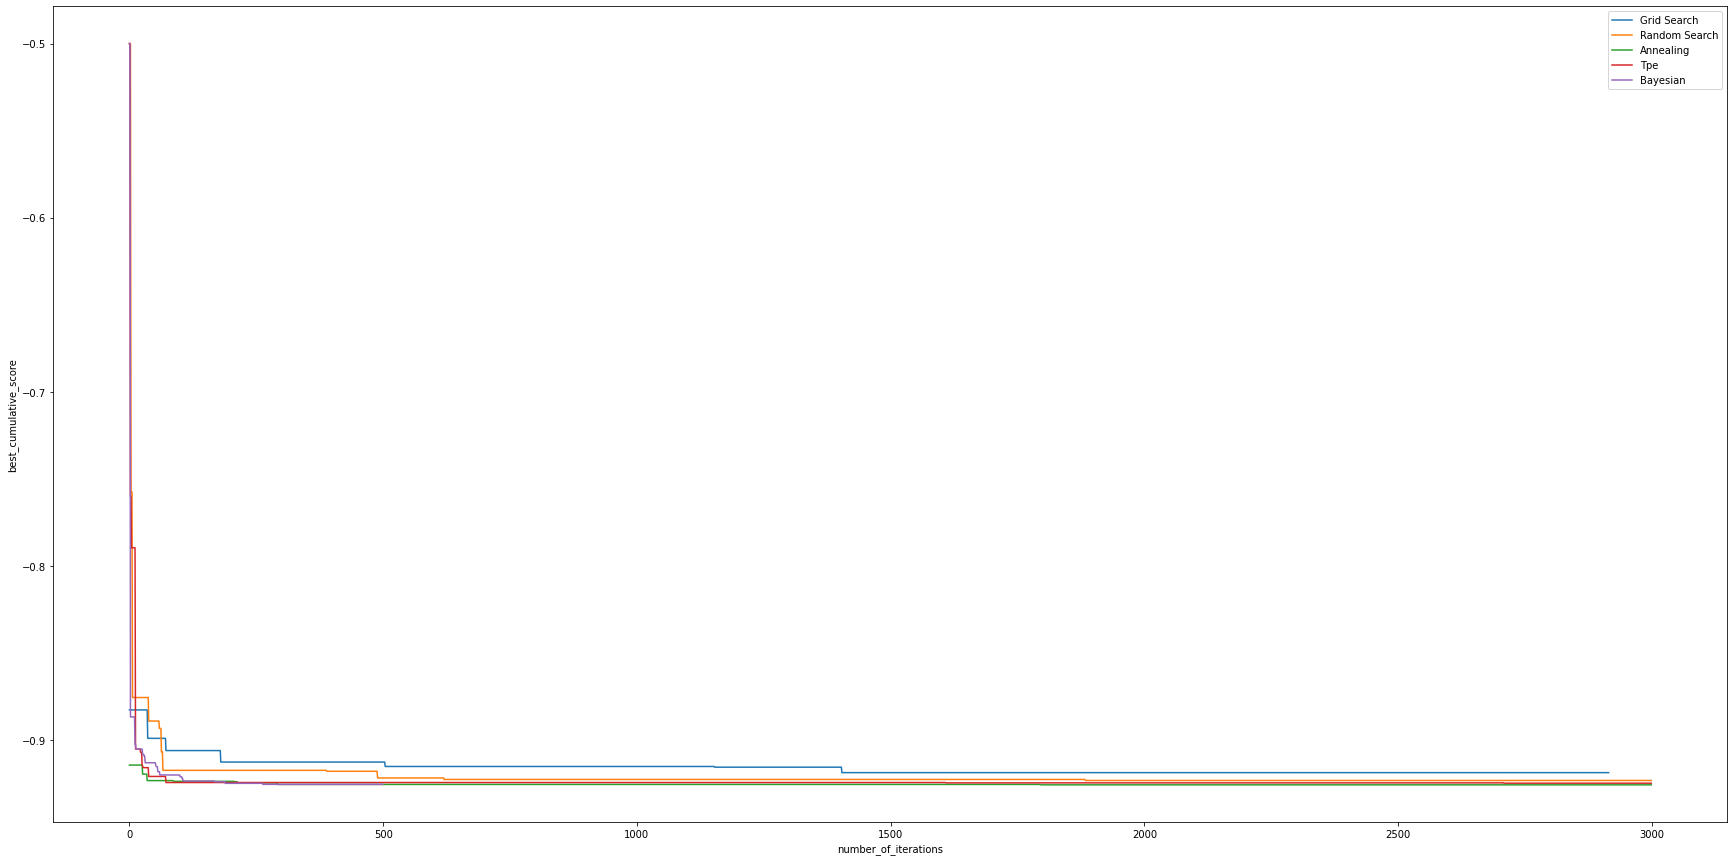

In [32]:
scores_df=pd.DataFrame(index=range(3000))
scores_df['Grid Search']=grid_search_results_df['score'].cummin()
scores_df['Random Search']=random_search_results_df['score'].cummin()
scores_df['Annealing']=anneal_results_df['score'].cummin()
scores_df['Tpe'] = tpe_results_df['score'].cummin()
scores_df['Bayesian'] = bayesian_results_df['score'].cummin()

ax = scores_df.plot(figsize=(30, 15))

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")